In [15]:
import pennylane as qml

from pennylane import numpy as np

import matplotlib.pyplot as plt

import numpy as np_
import scipy as sp

import random
dev = qml.device('default.mixed', wires = 1)

Paras_global, Phi_global = np_.zeros(2), 0

In [16]:
# == Hamiltonian setup == 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [17]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global
    theta_x, phi_z = Paras_global[0], Paras_global[1]

    qml.RX(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

In [18]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    
    return -CFI

In [19]:
def BFGS(Sweep_Data, Paras):
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((len(PHI), len(Paras) + 2)) 
    
    Data[:, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    CFI_INDEX, PARAS_INDEX, = 1, 2
    global Phi_global

    
    for Phi_Index in range(len(PHI)):
        # Set Phi(Currently sweeping)
        Phi_global = Data[Phi_Index][0]
            
        # Constraints(gamma = 0.99..) 
        tau_upper = 18
        Constraints = [(-float('inf'), float('inf'))] * len(Paras)
        
        # Push paras to global var
        Result_BFGS = sp.optimize.minimize(Cost_function, Paras, method = 'L-BFGS-B', bounds = Constraints)
        Data[Phi_Index][CFI_INDEX] = -Result_BFGS.fun
        
        # Store data in array
        for Paras_Index_Array in range(len(Paras)):
            Data[Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

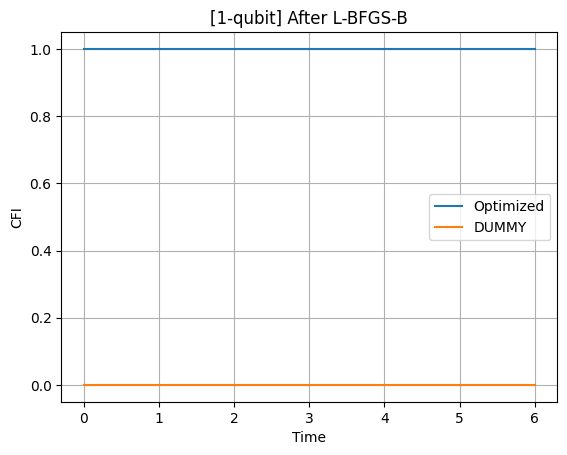

In [25]:
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 5e-1])

Para_init = np_.zeros(2)
Para_init[:4] = random.uniform(0, 1)

Optimized_Result = BFGS(Sweep_data, Para_init)
DUMMY = np.zeros(len(Optimized_Result[:, 0]))

plt.title(f'[1-qubit] After L-BFGS-B')
plt.plot(Optimized_Result[:, 0], Optimized_Result[:, 1], label = 'Optimized')
plt.plot(Optimized_Result[:, 0], DUMMY, label = 'DUMMY')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

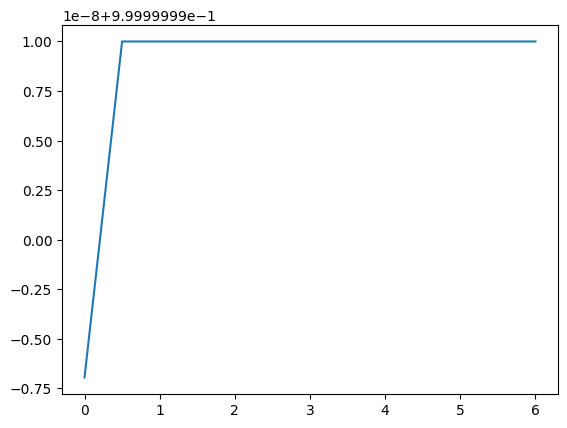

In [21]:
@qml.qnode(dev)
def circuit_1(phi):
    qml.Hadamard(wires=0)
    
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    qml.Hadamard(wires=0)    
        
    return qml.density_matrix(wires = 0)

PHI = np.arange(1e-4, np.pi * 2 + 1e-4, 5e-1)
Data = np_.zeros(len(PHI))

for i in range(len(PHI)):
    Data[i] = qml.qinfo.classical_fisher(circuit_1)(PHI[i])
    
plt.plot(PHI , Data)